In [1]:
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

from public_tests_a1 import * 

tf.keras.backend.set_floatx('float64')
from assigment_utils import *

tf.autograph.set_verbosity(0)

In [2]:
#Creating the dataset

X,y, x_ideal, y_ideal = gen_data(18,2,0.7)
print("X.shape: ", X.shape, "y.shape: ", y.shape)

X.shape:  (18,) y.shape:  (18,)


In [3]:
#Splitting the dataset

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X_train.shape (12,) y_train.shape (12,)
X_test.shape (6,) y_test.shape (6,)


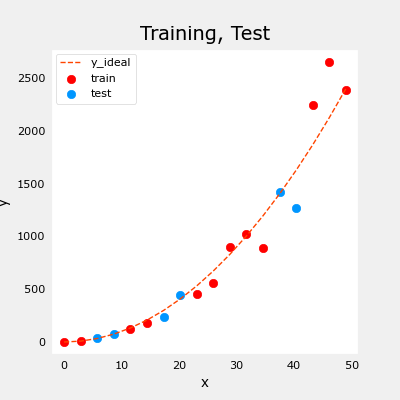

In [4]:
#Plotting the data

fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color='orangered', label="y_ideal", lw=1)
ax.set_title("Training, Test", fontsize=14)
ax.set_xlabel('x')
ax.set_ylabel('y')

ax.scatter(X_train, y_train, color = 'red', label = 'train')
ax.scatter(X_test, y_test, color = dlc['dlblue'], label = 'test')
ax.legend(loc='upper left')
plt.show()

In [5]:
#Evaluating error on the dataset for a linear regression model

def eval_mse(y, yhat):
    
    m = len(y)
    err = 0.0
    
    for i in range(m):
        err_i = (yhat[i] - y[i])**2
        err += err_i
    err = err/(2*m)
    return(err)

In [6]:
y_hat = np.array([2.4, 4.2])
y_tmp = np.array([2.3, 4.1])

eval_mse(y_hat, y_tmp)

# BEGIN UNIT TEST
test_eval_mse(eval_mse)   
# END UNIT TEST

 All tests passed.


In [7]:
#Creating a model in sklearn, train on training data

degree = 10
lmodel = lin_model(degree)
lmodel.fit(X_train, y_train)

#predict on training data, find training error
y_hat = lmodel.predict(X_train)
err_train = lmodel.mse(y_train, y_hat)

#predict on test data, find test error
y_hat = lmodel.predict(X_test)
err_test = lmodel.mse(y_test, y_hat)

In [8]:
#Getting low training error, but high test error - High variance (overfitting) because of 10th degree polynomial

print(f"training err {err_train:0.2f}, test err {err_test:0.2f}")

training err 58.01, test err 171215.01


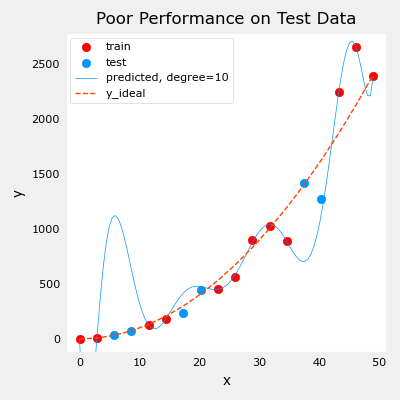

In [9]:
# plot predictions over data range 
x = np.linspace(0,int(X.max()),100)  # predict values for plot
y_pred = lmodel.predict(x).reshape(-1,1)

plt_train_test(X_train, y_train, X_test, y_test, x, y_pred, x_ideal, y_ideal, degree)

# Creating a CV set

| data             | % of total | Description |
|------------------|:----------:|:---------|
| training         | 60         | Data used to tune model parameters $w$ and $b$ in training or fitting |
| cross-validation | 20         | Data used to tune other model parameters like degree of polynomial, regularization or the architecture of a neural network.|
| test             | 20         | Data used to test the model after tuning to gauge performance on new data |

In [10]:
# Generate  data
X,y, x_ideal,y_ideal = gen_data(40, 5, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

#Splitting the data to train and cv/test set
X_train, X_, y_train, y_ = train_test_split(X,y, test_size=0.4, random_state=1)

#Splitting the data to cv and test set
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, test_size=0.5, random_state=1)

print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_cv.shape", X_cv.shape, "y_cv.shape", y_cv.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (40,) y.shape (40,)
X_train.shape (24,) y_train.shape (24,)
X_cv.shape (8,) y_cv.shape (8,)
X_test.shape (8,) y_test.shape (8,)


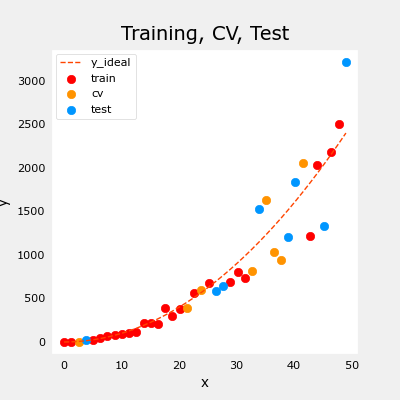

In [11]:
#Plot Train, Cross-Validation, Test

fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, CV, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",           label="train")
ax.scatter(X_cv, y_cv,       color = dlc["dlorange"], label="cv")
ax.scatter(X_test, y_test,   color = dlc["dlblue"],   label="test")
ax.legend(loc='upper left')
plt.show()

In [16]:
#Finding optimal degree

max_degree = 9 #Since 10 was overfit
err_train = np.zeros(max_degree)
err_cv = np.zeros(max_degree)
x = np.linspace(0, int(X.max()), 100)
y_pred = np.zeros((100, max_degree)) #Columns are lines to plot

for degree in range(max_degree):
    lmodel = lin_model(degree+1)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[degree] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[degree] = lmodel.mse(y_cv, yhat)
    y_pred[:, degree] = lmodel.predict(x)

optimal_degree = np.argmin(err_cv)+1

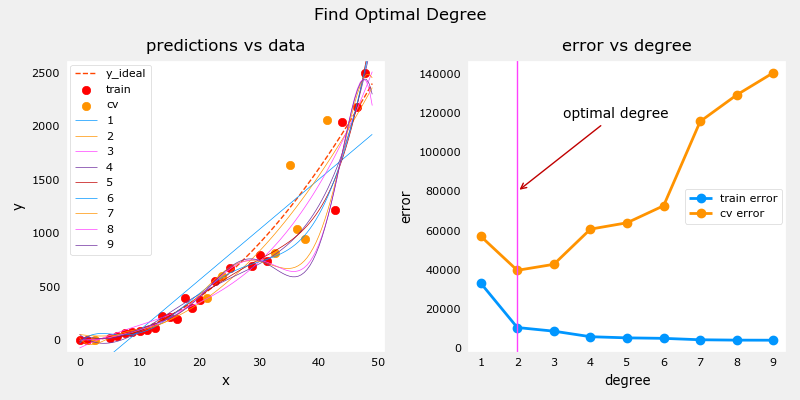

In [17]:
plt.close("all")
plt_optimal_degree(X_train, y_train, X_cv, y_cv, x, y_pred, x_ideal, y_ideal, 
                   err_train, err_cv, optimal_degree, max_degree)

In [23]:
#Tuning Regularization

lambda_range = np.array([0.0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100])
num_steps = len(lambda_range)
degree = 10
err_train = np.zeros(num_steps)
err_cv = np.zeros(num_steps)
x = np.linspace(0, int(X.max()), 100)
y_pred = np.zeros((100, num_steps))

for i in range(num_steps):
    lambda_ = lambda_range[i]
    lmodel = lin_model(degree, regularization=True, lambda_=lambda_)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[i] = lmodel.mse(y_train, yhat)
    
    yhat = lmodel.predict(X_cv)
    err_cv[i] = lmodel.mse(y_cv, yhat)
    y_pred[:, i] = lmodel.predict(x)

optimal_reg_idx = np.argmin(err_cv)

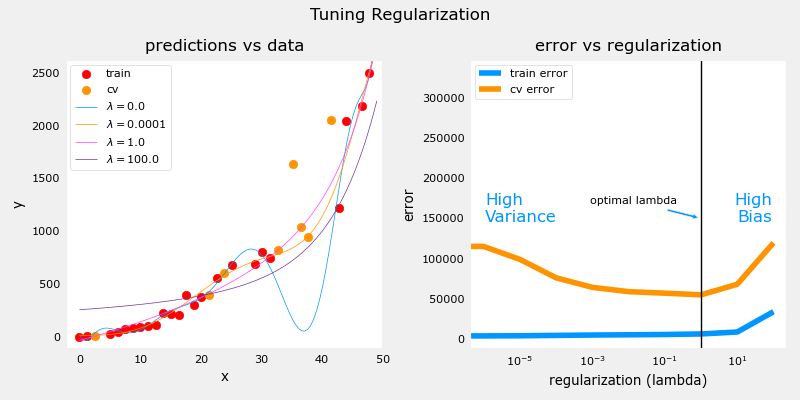

In [24]:
plt.close("all")
plt_tune_regularization(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, optimal_reg_idx, lambda_range)

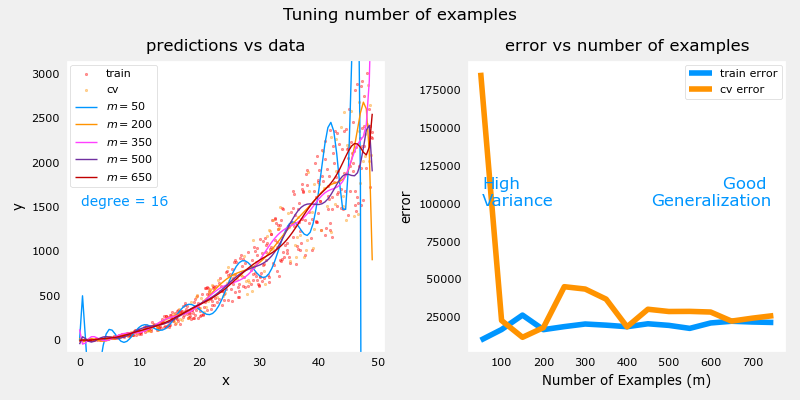

In [25]:
#Getting more data (To prevent overfitting)

X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range,degree = tune_m()
plt_tune_m(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range, degree)

# Evaluating a neural network

In [29]:
#Generate and split dataset

X, y, centers, classes, std = gen_blobs()

#Split the data
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.50, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_, test_size = 0.20, random_state=1)

print("X_train.shape: ", X_train.shape, "X_cv.shape: ", X_cv.shape, "X_test.shape: ", X_test.shape)

X_train.shape:  (400, 2) X_cv.shape:  (320, 2) X_test.shape:  (80, 2)


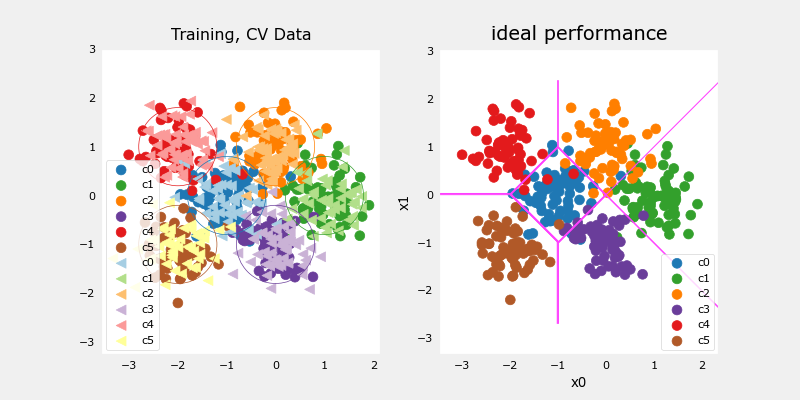

In [30]:
#training points (dots) and cross-validataion points (triangles) 

plt_train_eq_dist(X_train, y_train,classes, X_cv, y_cv, centers, std)

In [31]:
#Evaluating classification error for categorical model

def eval_cat_err(y, yhat):
    m = len(y)
    incorrect = 0
    for i in range(m):
        if(yhat[i] != y[i]):
            incorrect+=1
    cerr = incorrect/m
    return(cerr)

In [32]:
#Testing

y_hat = np.array([1, 2, 0])
y_tmp = np.array([1, 2, 3])
print(f"categorization error {np.squeeze(eval_cat_err(y_hat, y_tmp)):0.3f}, expected:0.333" )
y_hat = np.array([[1], [2], [0], [3]])
y_tmp = np.array([[1], [2], [1], [3]])
print(f"categorization error {np.squeeze(eval_cat_err(y_hat, y_tmp)):0.3f}, expected:0.250" )

# BEGIN UNIT TEST  
test_eval_cat_err(eval_cat_err)
# END UNIT TEST
# BEGIN UNIT TEST  
test_eval_cat_err(eval_cat_err)
# END UNIT TEST

categorization error 0.333, expected:0.333
categorization error 0.250, expected:0.250
 All tests passed.
 All tests passed.


In [33]:
#Creating complex model

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

tf.random.set_seed(1234)
model = Sequential(
    [
        Dense(120, activation='relu', name='L1'),
        Dense(40, activation='relu', name="L2"),
        Dense(6, activation='linear', name='L3')
    ], name="Complex"
)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
)

model.fit(
    X_train, y_train,
    epochs=1000
)

Epoch 1/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.1106
Epoch 2/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4281
Epoch 3/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3345
Epoch 4/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2896
Epoch 5/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2867
Epoch 6/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2918
Epoch 7/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2497
Epoch 8/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2298
Epoch 9/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2307
Epoch 10/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2071
Epoch 11/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2115
Epoch 12/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2070
Epoch 13/1000
13/13 [====

13/13 [==============================] - 0s 2ms/step - loss: 0.1645
Epoch 102/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1737
Epoch 103/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1935
Epoch 104/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1600
Epoch 105/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1483
Epoch 106/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1555
Epoch 107/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1678
Epoch 108/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1435
Epoch 109/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1419
Epoch 110/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1494
Epoch 111/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1538
Epoch 112/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1682
Epoch 113/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.1423
Epoch 200/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1381
Epoch 201/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1105
Epoch 202/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1005
Epoch 203/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0846
Epoch 204/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1125
Epoch 205/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1129
Epoch 206/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1219
Epoch 207/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1161
Epoch 208/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1137
Epoch 209/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1178
Epoch 210/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1017
Epoch 211/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.0800
Epoch 298/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0803
Epoch 299/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0765
Epoch 300/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0733
Epoch 301/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0544
Epoch 302/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0718
Epoch 303/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0877
Epoch 304/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0687
Epoch 305/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0671
Epoch 306/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0575
Epoch 307/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0773
Epoch 308/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0779
Epoch 309/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.0844
Epoch 396/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0704
Epoch 397/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0700
Epoch 398/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0591
Epoch 399/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0586
Epoch 400/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0628
Epoch 401/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1717
Epoch 402/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1648
Epoch 403/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1616
Epoch 404/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1326
Epoch 405/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1367
Epoch 406/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1098
Epoch 407/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.0564
Epoch 494/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0469
Epoch 495/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0463
Epoch 496/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0425
Epoch 497/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0421
Epoch 498/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0474
Epoch 499/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0467
Epoch 500/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0444
Epoch 501/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0477
Epoch 502/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0462
Epoch 503/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0528
Epoch 504/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0542
Epoch 505/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.0284
Epoch 592/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0263
Epoch 593/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0289
Epoch 594/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0236
Epoch 595/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0222
Epoch 596/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0233
Epoch 597/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0238
Epoch 598/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0235
Epoch 599/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0237
Epoch 600/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0322
Epoch 601/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0295
Epoch 602/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0308
Epoch 603/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.1024
Epoch 690/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0887
Epoch 691/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0616
Epoch 692/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0498
Epoch 693/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0524
Epoch 694/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0383
Epoch 695/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0461
Epoch 696/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0401
Epoch 697/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0360
Epoch 698/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0328
Epoch 699/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0362
Epoch 700/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0301
Epoch 701/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.0214
Epoch 788/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0242
Epoch 789/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0236
Epoch 790/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0230
Epoch 791/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0208
Epoch 792/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0244
Epoch 793/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0254
Epoch 794/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0217
Epoch 795/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0209
Epoch 796/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0203
Epoch 797/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0206
Epoch 798/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0213
Epoch 799/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.0294
Epoch 886/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0263
Epoch 887/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0282
Epoch 888/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0245
Epoch 889/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0260
Epoch 890/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0263
Epoch 891/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0247
Epoch 892/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0266
Epoch 893/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0261
Epoch 894/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0248
Epoch 895/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0248
Epoch 896/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0254
Epoch 897/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.0236
Epoch 984/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0221
Epoch 985/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0238
Epoch 986/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0241
Epoch 987/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0232
Epoch 988/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0243
Epoch 989/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0283
Epoch 990/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0250
Epoch 991/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0228
Epoch 992/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0219
Epoch 993/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0216
Epoch 994/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0214
Epoch 995/1000
13/1

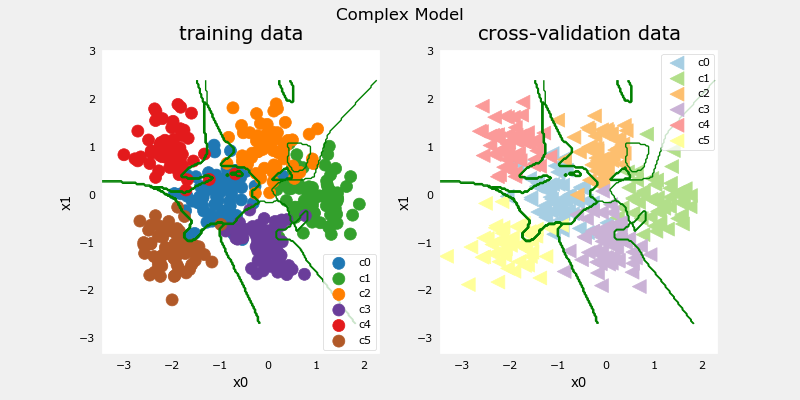

In [34]:
#Overfitting plot

model_predict = lambda Xl: np.argmax(tf.nn.softmax(model.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict,X_train,y_train, classes, X_cv, y_cv, suptitle="Complex Model")

In [36]:
training_cerr_complex = eval_cat_err(y_train, model_predict(X_train))
cv_cerr_complex = eval_cat_err(y_cv, model_predict(X_cv))
print(f"categorization error, training, complex model: {training_cerr_complex:0.3f}")
print(f"categorization error, cv,       complex model: {cv_cerr_complex:0.3f}")

categorization error, training, complex model: 0.010
categorization error, cv,       complex model: 0.119


In [37]:
tf.random.set_seed(1234)
model_s = Sequential(
    [
        Dense(6, activation='relu', name='L1'),
        Dense(6, activation='linear', name='L2')
    ], name = "Simple"
)
model_s.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
)

model_s.fit(
    X_train,y_train, epochs = 1000
)

Epoch 1/1000
13/13 [==============================] - 0s 846us/step - loss: 1.7306
Epoch 2/1000
13/13 [==============================] - 0s 846us/step - loss: 1.4468
Epoch 3/1000
13/13 [==============================] - 0s 846us/step - loss: 1.2902
Epoch 4/1000
13/13 [==============================] - 0s 846us/step - loss: 1.1367
Epoch 5/1000
13/13 [==============================] - 0s 846us/step - loss: 0.9710
Epoch 6/1000
13/13 [==============================] - 0s 923us/step - loss: 0.7947
Epoch 7/1000
13/13 [==============================] - 0s 846us/step - loss: 0.6499
Epoch 8/1000
13/13 [==============================] - 0s 846us/step - loss: 0.5378
Epoch 9/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.4652
Epoch 10/1000
13/13 [==============================] - 0s 923us/step - loss: 0.4184
Epoch 11/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.3860
Epoch 12/1000
13/13 [==============================] - 0s 846us/step - loss: 0.3641

Epoch 99/1000
13/13 [==============================] - 0s 846us/step - loss: 0.1991
Epoch 100/1000
13/13 [==============================] - 0s 846us/step - loss: 0.2006
Epoch 101/1000
13/13 [==============================] - 0s 846us/step - loss: 0.2010
Epoch 102/1000
13/13 [==============================] - 0s 846us/step - loss: 0.2018
Epoch 103/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.2026
Epoch 104/1000
13/13 [==============================] - 0s 923us/step - loss: 0.1988
Epoch 105/1000
13/13 [==============================] - 0s 923us/step - loss: 0.1974
Epoch 106/1000
13/13 [==============================] - 0s 923us/step - loss: 0.1966
Epoch 107/1000
13/13 [==============================] - 0s 923us/step - loss: 0.1963
Epoch 108/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1969
Epoch 109/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1987
Epoch 110/1000
13/13 [==============================] - 0s 923us/step

13/13 [==============================] - 0s 769us/step - loss: 0.1859
Epoch 196/1000
13/13 [==============================] - 0s 846us/step - loss: 0.1856
Epoch 197/1000
13/13 [==============================] - 0s 846us/step - loss: 0.1879
Epoch 198/1000
13/13 [==============================] - 0s 846us/step - loss: 0.1884
Epoch 199/1000
13/13 [==============================] - 0s 846us/step - loss: 0.1894
Epoch 200/1000
13/13 [==============================] - 0s 846us/step - loss: 0.1860
Epoch 201/1000
13/13 [==============================] - 0s 846us/step - loss: 0.1869
Epoch 202/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1837
Epoch 203/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1861
Epoch 204/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1869
Epoch 205/1000
13/13 [==============================] - 0s 846us/step - loss: 0.1846
Epoch 206/1000
13/13 [==============================] - 0s 846us/step - loss: 0.1881
E

13/13 [==============================] - 0s 846us/step - loss: 0.1801
Epoch 292/1000
13/13 [==============================] - 0s 923us/step - loss: 0.1793
Epoch 293/1000
13/13 [==============================] - 0s 846us/step - loss: 0.1815
Epoch 294/1000
13/13 [==============================] - 0s 846us/step - loss: 0.1784
Epoch 295/1000
13/13 [==============================] - 0s 846us/step - loss: 0.1867
Epoch 296/1000
13/13 [==============================] - 0s 846us/step - loss: 0.1805
Epoch 297/1000
13/13 [==============================] - 0s 846us/step - loss: 0.1855
Epoch 298/1000
13/13 [==============================] - 0s 769us/step - loss: 0.1816
Epoch 299/1000
13/13 [==============================] - 0s 769us/step - loss: 0.1798
Epoch 300/1000
13/13 [==============================] - 0s 769us/step - loss: 0.1817
Epoch 301/1000
13/13 [==============================] - 0s 846us/step - loss: 0.1823
Epoch 302/1000
13/13 [==============================] - 0s 846us/step - loss: 0.

13/13 [==============================] - 0s 846us/step - loss: 0.1771
Epoch 388/1000
13/13 [==============================] - 0s 923us/step - loss: 0.1809
Epoch 389/1000
13/13 [==============================] - 0s 846us/step - loss: 0.1807
Epoch 390/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1792
Epoch 391/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1767
Epoch 392/1000
13/13 [==============================] - 0s 923us/step - loss: 0.1767
Epoch 393/1000
13/13 [==============================] - 0s 923us/step - loss: 0.1763
Epoch 394/1000
13/13 [==============================] - 0s 923us/step - loss: 0.1768
Epoch 395/1000
13/13 [==============================] - 0s 923us/step - loss: 0.1789
Epoch 396/1000
13/13 [==============================] - 0s 846us/step - loss: 0.1801
Epoch 397/1000
13/13 [==============================] - 0s 846us/step - loss: 0.1805
Epoch 398/1000
13/13 [==============================] - 0s 769us/step - loss: 0.1783

13/13 [==============================] - 0s 769us/step - loss: 0.1763
Epoch 484/1000
13/13 [==============================] - 0s 769us/step - loss: 0.1767
Epoch 485/1000
13/13 [==============================] - 0s 923us/step - loss: 0.1780
Epoch 486/1000
13/13 [==============================] - 0s 923us/step - loss: 0.1739
Epoch 487/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1781
Epoch 488/1000
13/13 [==============================] - 0s 846us/step - loss: 0.1755
Epoch 489/1000
13/13 [==============================] - 0s 846us/step - loss: 0.1766
Epoch 490/1000
13/13 [==============================] - 0s 846us/step - loss: 0.1783
Epoch 491/1000
13/13 [==============================] - 0s 846us/step - loss: 0.1769
Epoch 492/1000
13/13 [==============================] - 0s 846us/step - loss: 0.1752
Epoch 493/1000
13/13 [==============================] - 0s 846us/step - loss: 0.1772
Epoch 494/1000
13/13 [==============================] - 0s 846us/step - loss: 0.17

Epoch 580/1000
13/13 [==============================] - 0s 846us/step - loss: 0.1725
Epoch 581/1000
13/13 [==============================] - 0s 769us/step - loss: 0.1731
Epoch 582/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.1709
Epoch 583/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1727
Epoch 584/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1742
Epoch 585/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1721
Epoch 586/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1730
Epoch 587/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1728
Epoch 588/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1718
Epoch 589/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1710
Epoch 590/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1787
Epoch 591/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.17

13/13 [==============================] - 0s 846us/step - loss: 0.1712
Epoch 677/1000
13/13 [==============================] - 0s 769us/step - loss: 0.1711
Epoch 678/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1718
Epoch 679/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1795
Epoch 680/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1709
Epoch 681/1000
13/13 [==============================] - 0s 846us/step - loss: 0.1703
Epoch 682/1000
13/13 [==============================] - 0s 923us/step - loss: 0.1717
Epoch 683/1000
13/13 [==============================] - 0s 923us/step - loss: 0.1758
Epoch 684/1000
13/13 [==============================] - 0s 923us/step - loss: 0.1699
Epoch 685/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.1753
Epoch 686/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1728
Epoch 687/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.1733
E

13/13 [==============================] - 0s 846us/step - loss: 0.1693
Epoch 773/1000
13/13 [==============================] - 0s 846us/step - loss: 0.1697
Epoch 774/1000
13/13 [==============================] - 0s 846us/step - loss: 0.1712
Epoch 775/1000
13/13 [==============================] - 0s 846us/step - loss: 0.1704
Epoch 776/1000
13/13 [==============================] - 0s 923us/step - loss: 0.1681
Epoch 777/1000
13/13 [==============================] - 0s 923us/step - loss: 0.1704
Epoch 778/1000
13/13 [==============================] - 0s 923us/step - loss: 0.1721
Epoch 779/1000
13/13 [==============================] - 0s 846us/step - loss: 0.1706
Epoch 780/1000
13/13 [==============================] - 0s 846us/step - loss: 0.1747
Epoch 781/1000
13/13 [==============================] - 0s 923us/step - loss: 0.1722
Epoch 782/1000
13/13 [==============================] - 0s 923us/step - loss: 0.1714
Epoch 783/1000
13/13 [==============================] - 0s 769us/step - loss: 0.

13/13 [==============================] - 0s 923us/step - loss: 0.1728
Epoch 869/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1682
Epoch 870/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1681
Epoch 871/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1684
Epoch 872/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1680
Epoch 873/1000
13/13 [==============================] - 0s 923us/step - loss: 0.1720
Epoch 874/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1705
Epoch 875/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1686
Epoch 876/1000
13/13 [==============================] - 0s 922us/step - loss: 0.1676
Epoch 877/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.1750
Epoch 878/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1728
Epoch 879/1000
13/13 [==============================] - 0s 923us/step - loss: 0.1733
Epoch 88

13/13 [==============================] - 0s 846us/step - loss: 0.1713
Epoch 966/1000
13/13 [==============================] - 0s 846us/step - loss: 0.1671
Epoch 967/1000
13/13 [==============================] - 0s 923us/step - loss: 0.1697
Epoch 968/1000
13/13 [==============================] - 0s 846us/step - loss: 0.1716
Epoch 969/1000
13/13 [==============================] - 0s 846us/step - loss: 0.1688
Epoch 970/1000
13/13 [==============================] - 0s 923us/step - loss: 0.1672
Epoch 971/1000
13/13 [==============================] - 0s 769us/step - loss: 0.1664
Epoch 972/1000
13/13 [==============================] - 0s 846us/step - loss: 0.1684
Epoch 973/1000
13/13 [==============================] - 0s 923us/step - loss: 0.1660
Epoch 974/1000
13/13 [==============================] - 0s 846us/step - loss: 0.1678
Epoch 975/1000
13/13 [==============================] - 0s 846us/step - loss: 0.1675
Epoch 976/1000
13/13 [==============================] - 0s 846us/step - loss: 0.

In [38]:
# BEGIN UNIT TEST
model_s.summary()

model_s_test(model_s, classes, X_train.shape[1])
# END UNIT TEST

Model: "Simple"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
L1 (Dense)                   (None, 6)                 18        
_________________________________________________________________
L2 (Dense)                   (None, 6)                 42        
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________
All tests passed!


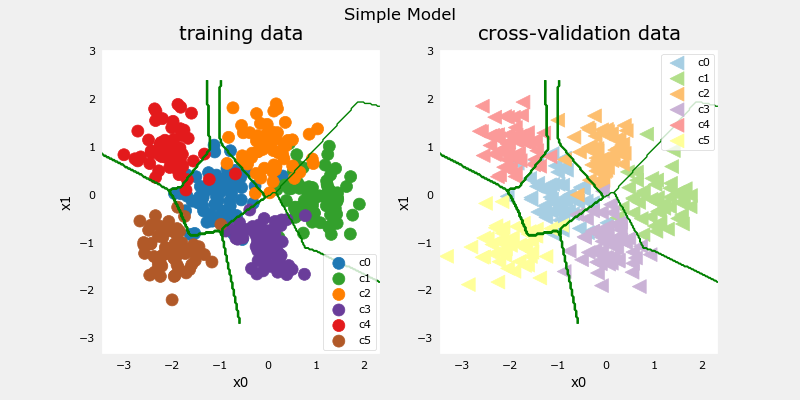

In [39]:
#make a model for plotting routines to call
model_predict_s = lambda Xl: np.argmax(tf.nn.softmax(model_s.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict_s,X_train,y_train, classes, X_cv, y_cv, suptitle="Simple Model")

In [40]:
#Error - bigger on training set, better on CV set

training_cerr_simple = eval_cat_err(y_train, model_predict_s(X_train))
cv_cerr_simple = eval_cat_err(y_cv, model_predict_s(X_cv))
print(f"categorization error, training, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

categorization error, training, simple model, 0.062, complex model: 0.010
categorization error, cv,       simple model, 0.087, complex model: 0.119


In [43]:
#Complex Model with Regularization

tf.random.set_seed(1234)
model_r = Sequential(
    [
        Dense(120, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.1), name='L1'),
        Dense(40, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.1), name='L2'),
        Dense(6, activation='linear', name='L3')
    ], name= 'ComplexRegularized'
)
model_r.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
)

model_r.fit(
    X_train, y_train,
    epochs=1000
)


Epoch 1/1000
13/13 [==============================] - 0s 1ms/step - loss: 4.4464
Epoch 2/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.7086
Epoch 3/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.3465
Epoch 4/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.0870
Epoch 5/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.0137
Epoch 6/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.9718
Epoch 7/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.9481
Epoch 8/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.8934
Epoch 9/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.8171
Epoch 10/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.7715
Epoch 11/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.7611
Epoch 12/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.7521
Epoch 13/1000
13/13 [====

13/13 [==============================] - 0s 1ms/step - loss: 0.4874
Epoch 102/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4759
Epoch 103/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4739
Epoch 104/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4682
Epoch 105/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5125
Epoch 106/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4548
Epoch 107/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4610
Epoch 108/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4702
Epoch 109/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4565
Epoch 110/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4568
Epoch 111/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4550
Epoch 112/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4541
Epoch 113/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.4080
Epoch 200/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4032
Epoch 201/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4268
Epoch 202/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3954
Epoch 203/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3980
Epoch 204/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4088
Epoch 205/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4571
Epoch 206/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4315
Epoch 207/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4097
Epoch 208/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4166
Epoch 209/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4393
Epoch 210/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4124
Epoch 211/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3841
Epoch 298/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3884
Epoch 299/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3926
Epoch 300/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4250
Epoch 301/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3915
Epoch 302/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3894
Epoch 303/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3858
Epoch 304/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3804
Epoch 305/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3810
Epoch 306/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3883
Epoch 307/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3922
Epoch 308/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3879
Epoch 309/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3932
Epoch 396/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3799
Epoch 397/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3915
Epoch 398/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3771
Epoch 399/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3753
Epoch 400/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3727
Epoch 401/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3584
Epoch 402/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3613
Epoch 403/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3600
Epoch 404/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3617
Epoch 405/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3545
Epoch 406/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3600
Epoch 407/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3510
Epoch 494/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3548
Epoch 495/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3525
Epoch 496/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3736
Epoch 497/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4008
Epoch 498/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3497
Epoch 499/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3444
Epoch 500/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3610
Epoch 501/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3546
Epoch 502/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3586
Epoch 503/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3814
Epoch 504/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3645
Epoch 505/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3489
Epoch 592/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3452
Epoch 593/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3429
Epoch 594/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3425
Epoch 595/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4209
Epoch 596/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3978
Epoch 597/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3565
Epoch 598/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3443
Epoch 599/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3419
Epoch 600/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3529
Epoch 601/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3345
Epoch 602/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3436
Epoch 603/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3976
Epoch 690/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3724
Epoch 691/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3471
Epoch 692/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3554
Epoch 693/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3445
Epoch 694/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3483
Epoch 695/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3390
Epoch 696/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3378
Epoch 697/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3355
Epoch 698/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3517
Epoch 699/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3456
Epoch 700/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3493
Epoch 701/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3368
Epoch 788/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3307
Epoch 789/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3382
Epoch 790/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3355
Epoch 791/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3734
Epoch 792/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3761
Epoch 793/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3444
Epoch 794/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3632
Epoch 795/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3406
Epoch 796/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3788
Epoch 797/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3315
Epoch 798/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3506
Epoch 799/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3704
Epoch 886/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3419
Epoch 887/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3491
Epoch 888/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3509
Epoch 889/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3373
Epoch 890/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3713
Epoch 891/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3285
Epoch 892/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3294
Epoch 893/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3340
Epoch 894/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3266
Epoch 895/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3464
Epoch 896/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3392
Epoch 897/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3174
Epoch 984/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3339
Epoch 985/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3361
Epoch 986/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3253
Epoch 987/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3248
Epoch 988/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3199
Epoch 989/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3323
Epoch 990/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3463
Epoch 991/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3422
Epoch 992/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3354
Epoch 993/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3225
Epoch 994/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3282
Epoch 995/1000
13/1

In [44]:
# BEGIN UNIT TEST
model_r.summary()

model_r_test(model_r, classes, X_train.shape[1]) 
# END UNIT TEST

Model: "ComplexRegularized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
L1 (Dense)                   (None, 120)               360       
_________________________________________________________________
L2 (Dense)                   (None, 40)                4840      
_________________________________________________________________
L3 (Dense)                   (None, 6)                 246       
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
ddd
All tests passed!


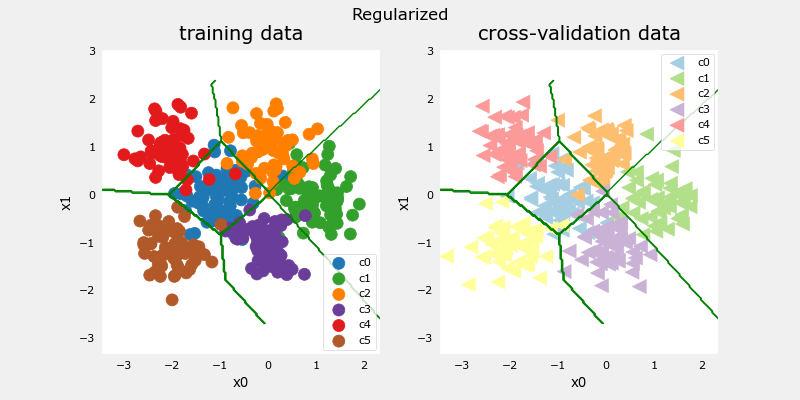

In [45]:
#make a model for plotting routines to call
model_predict_r = lambda Xl: np.argmax(tf.nn.softmax(model_r.predict(Xl)).numpy(),axis=1)
 
plt_nn(model_predict_r, X_train,y_train, classes, X_cv, y_cv, suptitle="Regularized")

In [46]:
#Worst training set performance, but lowest CV (generalization) error 

training_cerr_reg = eval_cat_err(y_train, model_predict_r(X_train))
cv_cerr_reg = eval_cat_err(y_cv, model_predict_r(X_cv))
test_cerr_reg = eval_cat_err(y_test, model_predict_r(X_test))
print(f"categorization error, training, regularized: {training_cerr_reg:0.3f}, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       regularized: {cv_cerr_reg:0.3f}, simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

categorization error, training, regularized: 0.072, simple model, 0.062, complex model: 0.010
categorization error, cv,       regularized: 0.066, simple model, 0.087, complex model: 0.119


In [47]:
#Finding optimal regularization value

tf.random.set_seed(1234)
lambdas = [0.0, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3]
models=[None] * len(lambdas)
for i in range(len(lambdas)):
    lambda_ = lambdas[i]
    models[i] =  Sequential(
        [
            Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(classes, activation = 'linear')
        ]
    )
    models[i].compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(0.01),
    )

    models[i].fit(
        X_train,y_train,
        epochs=1000
    )
    print(f"Finished lambda = {lambda_}")


Epoch 1/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.1106
Epoch 2/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4281
Epoch 3/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3345
Epoch 4/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2896
Epoch 5/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2867
Epoch 6/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2918
Epoch 7/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2497
Epoch 8/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2298
Epoch 9/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2307
Epoch 10/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2071
Epoch 11/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2115
Epoch 12/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2070
Epoch 13/1000
13/13 [====

13/13 [==============================] - 0s 1ms/step - loss: 0.1645
Epoch 102/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1737
Epoch 103/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1935
Epoch 104/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1600
Epoch 105/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1483
Epoch 106/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1555
Epoch 107/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1678
Epoch 108/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1435
Epoch 109/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1419
Epoch 110/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1494
Epoch 111/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1538
Epoch 112/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1682
Epoch 113/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.1423
Epoch 200/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1381
Epoch 201/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1105
Epoch 202/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1005
Epoch 203/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0846
Epoch 204/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1125
Epoch 205/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1129
Epoch 206/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1219
Epoch 207/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1161
Epoch 208/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1137
Epoch 209/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1178
Epoch 210/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1017
Epoch 211/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.0800
Epoch 298/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0803
Epoch 299/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0765
Epoch 300/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0733
Epoch 301/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0544
Epoch 302/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0718
Epoch 303/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0877
Epoch 304/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0687
Epoch 305/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0671
Epoch 306/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0575
Epoch 307/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0773
Epoch 308/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0779
Epoch 309/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.0844
Epoch 396/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0704
Epoch 397/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0700
Epoch 398/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0591
Epoch 399/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0586
Epoch 400/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0628
Epoch 401/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1717
Epoch 402/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1648
Epoch 403/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1616
Epoch 404/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1326
Epoch 405/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1367
Epoch 406/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1098
Epoch 407/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.0564
Epoch 494/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0469
Epoch 495/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0463
Epoch 496/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0425
Epoch 497/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0421
Epoch 498/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0474
Epoch 499/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0467
Epoch 500/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0444
Epoch 501/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0477
Epoch 502/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0462
Epoch 503/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0528
Epoch 504/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0542
Epoch 505/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.0284
Epoch 592/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0263
Epoch 593/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0289
Epoch 594/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0236
Epoch 595/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0222
Epoch 596/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0233
Epoch 597/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0238
Epoch 598/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0235
Epoch 599/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0237
Epoch 600/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0322
Epoch 601/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0295
Epoch 602/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0308
Epoch 603/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.1024
Epoch 690/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0887
Epoch 691/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0616
Epoch 692/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0498
Epoch 693/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0524
Epoch 694/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0383
Epoch 695/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0461
Epoch 696/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0401
Epoch 697/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0360
Epoch 698/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0328
Epoch 699/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0362
Epoch 700/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0301
Epoch 701/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.0214
Epoch 788/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0242
Epoch 789/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0236
Epoch 790/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0230
Epoch 791/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0208
Epoch 792/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0244
Epoch 793/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0254
Epoch 794/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0217
Epoch 795/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0209
Epoch 796/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0203
Epoch 797/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0206
Epoch 798/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0213
Epoch 799/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.0294
Epoch 886/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0263
Epoch 887/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0282
Epoch 888/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0245
Epoch 889/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0260
Epoch 890/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0263
Epoch 891/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0247
Epoch 892/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0266
Epoch 893/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0261
Epoch 894/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0248
Epoch 895/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0248
Epoch 896/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0254
Epoch 897/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.0236
Epoch 984/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0221
Epoch 985/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0238
Epoch 986/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0241
Epoch 987/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0232
Epoch 988/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0243
Epoch 989/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0283
Epoch 990/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0250
Epoch 991/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0228
Epoch 992/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0219
Epoch 993/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0216
Epoch 994/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0214
Epoch 995/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.2478
Epoch 83/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2346
Epoch 84/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2324
Epoch 85/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2536
Epoch 86/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2255
Epoch 87/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2297
Epoch 88/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2306
Epoch 89/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2300
Epoch 90/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2262
Epoch 91/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2189
Epoch 92/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2184
Epoch 93/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2201
Epoch 94/1000
13/13 [=========

13/13 [==============================] - 0s 1ms/step - loss: 0.2208
Epoch 182/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2110
Epoch 183/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2122
Epoch 184/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2098
Epoch 185/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2084
Epoch 186/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1989
Epoch 187/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2045
Epoch 188/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2013
Epoch 189/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2033
Epoch 190/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2129
Epoch 191/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2110
Epoch 192/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2040
Epoch 193/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.2000
Epoch 280/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1983
Epoch 281/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1969
Epoch 282/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1901
Epoch 283/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1988
Epoch 284/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1857
Epoch 285/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1860
Epoch 286/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1946
Epoch 287/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1907
Epoch 288/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2126
Epoch 289/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2023
Epoch 290/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1985
Epoch 291/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.1793
Epoch 378/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1850
Epoch 379/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1849
Epoch 380/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1833
Epoch 381/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1820
Epoch 382/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1913
Epoch 383/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2015
Epoch 384/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1958
Epoch 385/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1810
Epoch 386/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1816
Epoch 387/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1793
Epoch 388/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1775
Epoch 389/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.1811
Epoch 476/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1756
Epoch 477/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1820
Epoch 478/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1972
Epoch 479/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1826
Epoch 480/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1786
Epoch 481/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1727
Epoch 482/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1761
Epoch 483/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1784
Epoch 484/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1865
Epoch 485/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1801
Epoch 486/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1695
Epoch 487/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.1668
Epoch 574/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1646
Epoch 575/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1633
Epoch 576/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1623
Epoch 577/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1674
Epoch 578/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1770
Epoch 579/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1626
Epoch 580/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1734
Epoch 581/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1641
Epoch 582/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1642
Epoch 583/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1660
Epoch 584/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1715
Epoch 585/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.1640
Epoch 672/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1693
Epoch 673/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1591
Epoch 674/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1650
Epoch 675/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1610
Epoch 676/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1566
Epoch 677/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1623
Epoch 678/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1564
Epoch 679/1000
13/13 [==============================] - ETA: 0s - loss: 0.131 - 0s 1ms/step - loss: 0.1675
Epoch 680/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1742
Epoch 681/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1790
Epoch 682/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.

13/13 [==============================] - 0s 1ms/step - loss: 0.1516
Epoch 770/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1537
Epoch 771/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1596
Epoch 772/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1531
Epoch 773/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1655
Epoch 774/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1720
Epoch 775/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1744
Epoch 776/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1563
Epoch 777/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1590
Epoch 778/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1543
Epoch 779/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1536
Epoch 780/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1526
Epoch 781/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.1567
Epoch 868/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1579
Epoch 869/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1508
Epoch 870/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1573
Epoch 871/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1512
Epoch 872/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1483
Epoch 873/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1507
Epoch 874/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1528
Epoch 875/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1563
Epoch 876/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1574
Epoch 877/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1532
Epoch 878/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1611
Epoch 879/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.1524
Epoch 966/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1482
Epoch 967/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1626
Epoch 968/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1713
Epoch 969/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1586
Epoch 970/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1675
Epoch 971/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1572
Epoch 972/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1543
Epoch 973/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1551
Epoch 974/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1573
Epoch 975/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1558
Epoch 976/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1493
Epoch 977/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3533
Epoch 65/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3558
Epoch 66/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3334
Epoch 67/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3456
Epoch 68/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3420
Epoch 69/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3175
Epoch 70/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3176
Epoch 71/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3266
Epoch 72/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2945
Epoch 73/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3038
Epoch 74/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3079
Epoch 75/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3156
Epoch 76/1000
13/13 [=========

13/13 [==============================] - 0s 1ms/step - loss: 0.2780
Epoch 164/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2863
Epoch 165/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2836
Epoch 166/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2751
Epoch 167/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2735
Epoch 168/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2831
Epoch 169/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2756
Epoch 170/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2754
Epoch 171/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2655
Epoch 172/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2590
Epoch 173/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2792
Epoch 174/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2796
Epoch 175/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.2679
Epoch 262/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2653
Epoch 263/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2528
Epoch 264/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2496
Epoch 265/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2681
Epoch 266/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2748
Epoch 267/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2691
Epoch 268/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2595
Epoch 269/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2501
Epoch 270/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2638
Epoch 271/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2488
Epoch 272/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2590
Epoch 273/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.2456
Epoch 360/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2712
Epoch 361/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2578
Epoch 362/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2887
Epoch 363/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2854
Epoch 364/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2674
Epoch 365/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2514
Epoch 366/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2513
Epoch 367/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2746
Epoch 368/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2747
Epoch 369/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2498
Epoch 370/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2489
Epoch 371/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.2328
Epoch 458/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2508
Epoch 459/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2407
Epoch 460/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2385
Epoch 461/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2616
Epoch 462/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2420
Epoch 463/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2382
Epoch 464/1000
13/13 [==============================] - ETA: 0s - loss: 0.139 - 0s 1ms/step - loss: 0.2448
Epoch 465/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2504
Epoch 466/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2577
Epoch 467/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2492
Epoch 468/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.

13/13 [==============================] - 0s 1ms/step - loss: 0.2409
Epoch 556/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2248
Epoch 557/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2315
Epoch 558/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2424
Epoch 559/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2582
Epoch 560/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2552
Epoch 561/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2392
Epoch 562/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2518
Epoch 563/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2296
Epoch 564/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2423
Epoch 565/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2346
Epoch 566/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2342
Epoch 567/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.2212
Epoch 654/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2405
Epoch 655/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2316
Epoch 656/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2244
Epoch 657/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2280
Epoch 658/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2265
Epoch 659/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2217
Epoch 660/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2351
Epoch 661/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2234
Epoch 662/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2297
Epoch 663/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2287
Epoch 664/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2537
Epoch 665/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.2275
Epoch 752/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2332
Epoch 753/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2187
Epoch 754/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2307
Epoch 755/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2266
Epoch 756/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2251
Epoch 757/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2315
Epoch 758/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2266
Epoch 759/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2236
Epoch 760/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2401
Epoch 761/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2431
Epoch 762/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2319
Epoch 763/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.2212
Epoch 850/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2196
Epoch 851/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2211
Epoch 852/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2321
Epoch 853/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2166
Epoch 854/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2278
Epoch 855/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2295
Epoch 856/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2205
Epoch 857/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2324
Epoch 858/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2211
Epoch 859/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2291
Epoch 860/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2217
Epoch 861/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.2318
Epoch 948/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2295
Epoch 949/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2165
Epoch 950/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2121
Epoch 951/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2133
Epoch 952/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2369
Epoch 953/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2243
Epoch 954/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2267
Epoch 955/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2148
Epoch 956/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2183
Epoch 957/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2261
Epoch 958/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2436
Epoch 959/1000
13/1

Epoch 46/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4719
Epoch 47/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4354
Epoch 48/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4829
Epoch 49/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4672
Epoch 50/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4401
Epoch 51/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4549
Epoch 52/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4391
Epoch 53/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4545
Epoch 54/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4341
Epoch 55/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4627
Epoch 56/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4228
Epoch 57/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4406
Epoch 58/1000
13

13/13 [==============================] - 0s 1ms/step - loss: 0.3635
Epoch 146/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3615
Epoch 147/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3911
Epoch 148/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3709
Epoch 149/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3614
Epoch 150/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3586
Epoch 151/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3585
Epoch 152/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3561
Epoch 153/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3813
Epoch 154/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3619
Epoch 155/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3649
Epoch 156/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3631
Epoch 157/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3369
Epoch 244/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3468
Epoch 245/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3472
Epoch 246/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3458
Epoch 247/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3313
Epoch 248/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3407
Epoch 249/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3521
Epoch 250/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3412
Epoch 251/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3704
Epoch 252/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3543
Epoch 253/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3425
Epoch 254/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3580
Epoch 255/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3273
Epoch 342/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3430
Epoch 343/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3294
Epoch 344/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3224
Epoch 345/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3210
Epoch 346/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3267
Epoch 347/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3359
Epoch 348/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3467
Epoch 349/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3143
Epoch 350/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3377
Epoch 351/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3183
Epoch 352/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3420
Epoch 353/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3055
Epoch 440/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3063
Epoch 441/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3159
Epoch 442/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3270
Epoch 443/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3191
Epoch 444/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3133
Epoch 445/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3239
Epoch 446/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3118
Epoch 447/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3383
Epoch 448/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3302
Epoch 449/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3083
Epoch 450/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3117
Epoch 451/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3586
Epoch 538/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3209
Epoch 539/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2946
Epoch 540/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3151
Epoch 541/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3265
Epoch 542/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3297
Epoch 543/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3176
Epoch 544/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3109
Epoch 545/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3033
Epoch 546/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3208
Epoch 547/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3347
Epoch 548/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3134
Epoch 549/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3340
Epoch 636/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3206
Epoch 637/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3102
Epoch 638/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3004
Epoch 639/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2979
Epoch 640/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2924
Epoch 641/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2917
Epoch 642/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3073
Epoch 643/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3169
Epoch 644/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2949
Epoch 645/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3102
Epoch 646/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3222
Epoch 647/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3022
Epoch 734/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3208
Epoch 735/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3123
Epoch 736/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3176
Epoch 737/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3273
Epoch 738/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3049
Epoch 739/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.3050
Epoch 740/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3130
Epoch 741/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3245
Epoch 742/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3511
Epoch 743/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2981
Epoch 744/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2957
Epoch 745/1000
1

13/13 [==============================] - 0s 1ms/step - loss: 0.3185
Epoch 832/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3020
Epoch 833/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2999
Epoch 834/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2981
Epoch 835/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2876
Epoch 836/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2885
Epoch 837/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2931
Epoch 838/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3015
Epoch 839/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2924
Epoch 840/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3144
Epoch 841/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2857
Epoch 842/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3091
Epoch 843/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3047
Epoch 930/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3171
Epoch 931/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3025
Epoch 932/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2939
Epoch 933/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2956
Epoch 934/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3315
Epoch 935/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2986
Epoch 936/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2862
Epoch 937/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2846
Epoch 938/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3029
Epoch 939/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2871
Epoch 940/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2850
Epoch 941/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.6171
Epoch 29/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6046
Epoch 30/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6245
Epoch 31/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6138
Epoch 32/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6378
Epoch 33/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6188
Epoch 34/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6609
Epoch 35/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6587
Epoch 36/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6282
Epoch 37/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5878
Epoch 38/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5705
Epoch 39/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5768
Epoch 40/1000
13/13 [=========

13/13 [==============================] - 0s 1ms/step - loss: 0.4486
Epoch 128/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4340
Epoch 129/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4457
Epoch 130/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4411
Epoch 131/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4718
Epoch 132/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4376
Epoch 133/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4273
Epoch 134/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4512
Epoch 135/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4458
Epoch 136/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4567
Epoch 137/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4315
Epoch 138/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4510
Epoch 139/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.4357
Epoch 226/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4371
Epoch 227/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4695
Epoch 228/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4047
Epoch 229/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4031
Epoch 230/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4150
Epoch 231/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4023
Epoch 232/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4166
Epoch 233/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3921
Epoch 234/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3898
Epoch 235/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3890
Epoch 236/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3963
Epoch 237/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.4095
Epoch 324/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4046
Epoch 325/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3951
Epoch 326/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3824
Epoch 327/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3739
Epoch 328/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3923
Epoch 329/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3759
Epoch 330/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3641
Epoch 331/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3680
Epoch 332/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3700
Epoch 333/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4051
Epoch 334/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3900
Epoch 335/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3819
Epoch 422/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3949
Epoch 423/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3729
Epoch 424/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3723
Epoch 425/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3629
Epoch 426/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3592
Epoch 427/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3591
Epoch 428/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3646
Epoch 429/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3617
Epoch 430/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3552
Epoch 431/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3467
Epoch 432/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3546
Epoch 433/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3615
Epoch 520/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3602
Epoch 521/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3425
Epoch 522/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3611
Epoch 523/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3701
Epoch 524/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3372
Epoch 525/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3461
Epoch 526/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3518
Epoch 527/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3366
Epoch 528/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3418
Epoch 529/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3717
Epoch 530/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3589
Epoch 531/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3234
Epoch 618/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.3666
Epoch 619/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3905
Epoch 620/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3792
Epoch 621/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3499
Epoch 622/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3506
Epoch 623/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3339
Epoch 624/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3266
Epoch 625/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.3235
Epoch 626/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.3377
Epoch 627/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3526
Epoch 628/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3644
Epoch 629/

13/13 [==============================] - 0s 1ms/step - loss: 0.3257
Epoch 716/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3310
Epoch 717/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3459
Epoch 718/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3696
Epoch 719/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4027
Epoch 720/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3473
Epoch 721/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3392
Epoch 722/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3264
Epoch 723/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3577
Epoch 724/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3511
Epoch 725/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3742
Epoch 726/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3558
Epoch 727/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3243
Epoch 814/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3294
Epoch 815/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3447
Epoch 816/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3470
Epoch 817/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3561
Epoch 818/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3352
Epoch 819/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3211
Epoch 820/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3581
Epoch 821/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3856
Epoch 822/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3392
Epoch 823/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3413
Epoch 824/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3403
Epoch 825/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3209
Epoch 912/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3239
Epoch 913/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3153
Epoch 914/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3464
Epoch 915/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3383
Epoch 916/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3459
Epoch 917/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3375
Epoch 918/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3303
Epoch 919/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3524
Epoch 920/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3599
Epoch 921/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3388
Epoch 922/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3469
Epoch 923/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 1.0284
Epoch 10/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.0016
Epoch 11/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.9683
Epoch 12/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.9504
Epoch 13/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.9524
Epoch 14/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.9500
Epoch 15/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.9075
Epoch 16/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.8961
Epoch 17/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.8946
Epoch 18/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.8974
Epoch 19/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.8728
Epoch 20/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.8463
Epoch 21/1000
13/13 [=========

Epoch 109/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5614
Epoch 110/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5551
Epoch 111/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5539
Epoch 112/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5501
Epoch 113/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5429
Epoch 114/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5430
Epoch 115/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5422
Epoch 116/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5442
Epoch 117/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5777
Epoch 118/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5710
Epoch 119/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5637
Epoch 120/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5547
Epoc

13/13 [==============================] - 0s 1ms/step - loss: 0.5041
Epoch 208/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5060
Epoch 209/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5147
Epoch 210/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4868
Epoch 211/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4933
Epoch 212/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4781
Epoch 213/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4768
Epoch 214/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4778
Epoch 215/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4822
Epoch 216/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4962
Epoch 217/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4872
Epoch 218/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4994
Epoch 219/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.4483
Epoch 306/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4747
Epoch 307/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4580
Epoch 308/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4517
Epoch 309/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4528
Epoch 310/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4420
Epoch 311/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4358
Epoch 312/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4391
Epoch 313/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4479
Epoch 314/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4500
Epoch 315/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4424
Epoch 316/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4400
Epoch 317/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.4301
Epoch 404/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4372
Epoch 405/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4209
Epoch 406/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4182
Epoch 407/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4315
Epoch 408/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4433
Epoch 409/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4187
Epoch 410/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4314
Epoch 411/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4556
Epoch 412/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4186
Epoch 413/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4261
Epoch 414/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4419
Epoch 415/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.4050
Epoch 502/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4194
Epoch 503/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4447
Epoch 504/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4713
Epoch 505/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4511
Epoch 506/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4484
Epoch 507/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4303
Epoch 508/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4030
Epoch 509/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4085
Epoch 510/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4034
Epoch 511/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4171
Epoch 512/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4094
Epoch 513/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3899
Epoch 600/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4048
Epoch 601/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3811
Epoch 602/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3963
Epoch 603/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3960
Epoch 604/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4078
Epoch 605/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4062
Epoch 606/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4323
Epoch 607/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4111
Epoch 608/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4204
Epoch 609/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4018
Epoch 610/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4288
Epoch 611/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3900
Epoch 698/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4123
Epoch 699/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3941
Epoch 700/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3848
Epoch 701/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3979
Epoch 702/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3843
Epoch 703/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3733
Epoch 704/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4032
Epoch 705/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3955
Epoch 706/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3935
Epoch 707/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4077
Epoch 708/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4006
Epoch 709/1000
13/1

13/13 [==============================] - 0s 1000us/step - loss: 0.3819
Epoch 796/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4294
Epoch 797/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3900
Epoch 798/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4082
Epoch 799/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3857
Epoch 800/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3871
Epoch 801/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3892
Epoch 802/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3772
Epoch 803/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3703
Epoch 804/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3647
Epoch 805/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3843
Epoch 806/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3837
Epoch 807/1000
1

13/13 [==============================] - 0s 1ms/step - loss: 0.3984
Epoch 894/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3896
Epoch 895/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4349
Epoch 896/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4009
Epoch 897/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3860
Epoch 898/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4113
Epoch 899/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4130
Epoch 900/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3933
Epoch 901/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4191
Epoch 902/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4013
Epoch 903/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3950
Epoch 904/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3678
Epoch 905/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3784
Epoch 992/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3695
Epoch 993/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3768
Epoch 994/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3748
Epoch 995/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3912
Epoch 996/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3966
Epoch 997/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4233
Epoch 998/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3610
Epoch 999/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3804
Epoch 1000/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3814
Finished lambda = 0.2
Epoch 1/1000
13/13 [==============================] - 0s 1ms/step - loss: 9.8240
Epoch 2/1000
13/13 [==============================] - 0s 1ms/step - loss: 2.2941


13/13 [==============================] - 0s 1ms/step - loss: 0.6955
Epoch 91/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6906
Epoch 92/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6777
Epoch 93/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6840
Epoch 94/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6716
Epoch 95/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6764
Epoch 96/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6624
Epoch 97/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6602
Epoch 98/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6746
Epoch 99/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6932
Epoch 100/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.7013
Epoch 101/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6920
Epoch 102/1000
13/13 [======

Epoch 189/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5706
Epoch 190/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5642
Epoch 191/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5839
Epoch 192/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5801
Epoch 193/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5664
Epoch 194/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5593
Epoch 195/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5601
Epoch 196/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5562
Epoch 197/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5705
Epoch 198/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5592
Epoch 199/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5657
Epoch 200/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5633
Epoc

13/13 [==============================] - 0s 1ms/step - loss: 0.5664
Epoch 288/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5609
Epoch 289/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5300
Epoch 290/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5308
Epoch 291/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5363
Epoch 292/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5152
Epoch 293/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5233
Epoch 294/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5243
Epoch 295/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5526
Epoch 296/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5256
Epoch 297/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5166
Epoch 298/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5176
Epoch 299/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.4973
Epoch 386/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4799
Epoch 387/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4963
Epoch 388/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5063
Epoch 389/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4968
Epoch 390/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4818
Epoch 391/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4857
Epoch 392/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4882
Epoch 393/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4835
Epoch 394/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4820
Epoch 395/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5112
Epoch 396/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5247
Epoch 397/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.5081
Epoch 484/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4698
Epoch 485/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4998
Epoch 486/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4739
Epoch 487/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4748
Epoch 488/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4635
Epoch 489/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4543
Epoch 490/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4666
Epoch 491/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4733
Epoch 492/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4962
Epoch 493/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4731
Epoch 494/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4574
Epoch 495/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.4932
Epoch 582/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4847
Epoch 583/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4794
Epoch 584/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4588
Epoch 585/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4756
Epoch 586/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4991
Epoch 587/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4629
Epoch 588/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4511
Epoch 589/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4323
Epoch 590/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4349
Epoch 591/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4466
Epoch 592/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4427
Epoch 593/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.4471
Epoch 680/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4333
Epoch 681/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4582
Epoch 682/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4382
Epoch 683/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4401
Epoch 684/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4363
Epoch 685/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4397
Epoch 686/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4422
Epoch 687/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4322
Epoch 688/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4228
Epoch 689/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4683
Epoch 690/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4577
Epoch 691/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.4717
Epoch 778/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4722
Epoch 779/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4331
Epoch 780/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4403
Epoch 781/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4867
Epoch 782/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4367
Epoch 783/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4404
Epoch 784/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4350
Epoch 785/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4190
Epoch 786/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4218
Epoch 787/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4293
Epoch 788/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4209
Epoch 789/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.4179
Epoch 876/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4315
Epoch 877/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4150
Epoch 878/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4233
Epoch 879/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4197
Epoch 880/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4269
Epoch 881/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4417
Epoch 882/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4555
Epoch 883/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4783
Epoch 884/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4646
Epoch 885/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4510
Epoch 886/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4065
Epoch 887/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.4121
Epoch 974/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4125
Epoch 975/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4048
Epoch 976/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4070
Epoch 977/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4101
Epoch 978/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4041
Epoch 979/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4240
Epoch 980/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4539
Epoch 981/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4386
Epoch 982/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4308
Epoch 983/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4063
Epoch 984/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4203
Epoch 985/1000
13/1

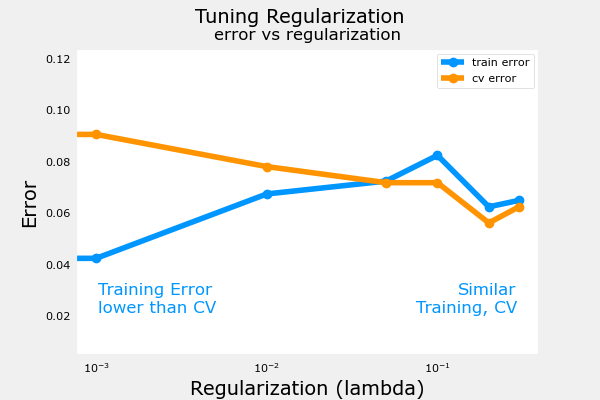

In [48]:
plot_iterate(lambdas, models, X_train, y_train, X_cv, y_cv)

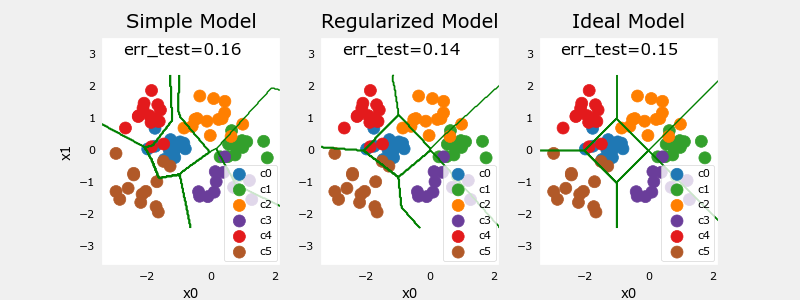

In [49]:
#Final test set performances

plt_compare(X_test,y_test, classes, model_predict_s, model_predict_r, centers)